#Import Libraries

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
%cd /content/drive/MyDrive/Computer Vision Portfolio/Rooftop Solar Panel Detection/

/content/drive/MyDrive/Data Science Portfolio/Rooftop Solar Panel Detection


In [26]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import cv2
import random
from pylab import rcParams
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from keras.layers import Input,Dense, Conv2D, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization, Add
from keras.models import Model

In [27]:
# Set directory paths
dir_train_images = "training"
dir_train_labels = "labels_training.csv"

In [28]:
# Read the labels CSV file
df = pd.read_csv("labels_training.csv")

In [29]:
df.head()

,id,label
0,0,0
1,1,0
2,2,1
3,3,1
4,4,1


In [30]:
# Check the distribution of labels
df['label'].value_counts()

label
0    995
1    505
Name: count, dtype: int64

In [31]:
# Function to load image data
def load_data(dir_data, dir_labels):
   labels_pd = pd.read_csv("labels_training.csv")
   ids = labels_pd['id'].values
   data = []
   for id in ids:
      filename = dir_data+ '/' + id.astype(str) + '.tif'
      image = cv2.imread(filename)
      data.append(image)
   data = np.array(data)
   labels = labels_pd['label'].values
   return data, labels

In [32]:
# Load image data
X, y = load_data(dir_train_images, dir_train_labels)

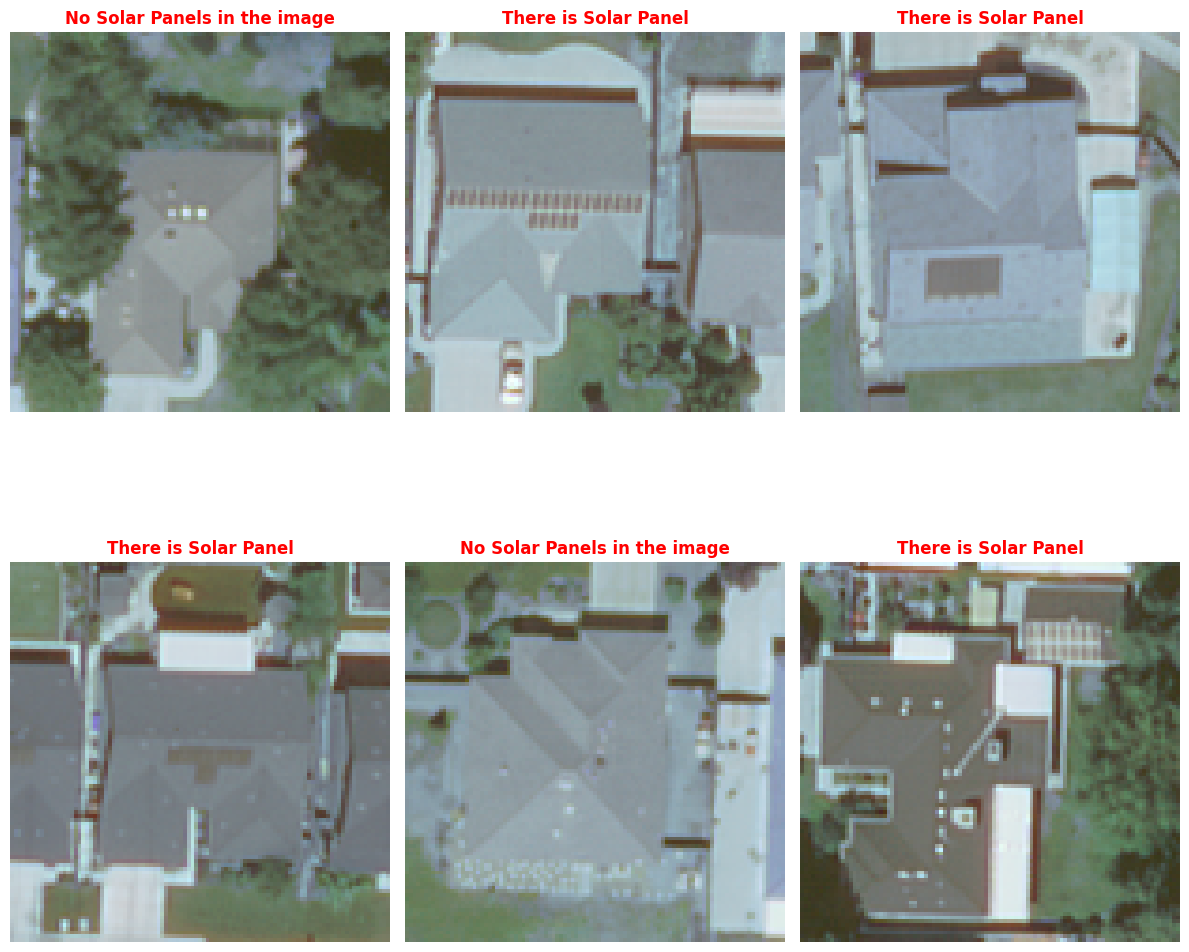

In [33]:
# Visualize some sample images
plt.figure(figsize=(12, 12))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    random_int = random.randint(0, len(X))
    plt.imshow(X[random_int])
    if y[random_int] == 0:
        title = "No Solar Panels in the image"
    else:
        title = "There is Solar Panel"
    plt.title(title, weight='bold', color='r')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [34]:
print(X.shape,y.shape)

(1500, 101, 101, 3) (1500,)


In [35]:
len(y)

1500

In [36]:
# scale pixel values
X = X / 255.0

#Build Model

In [37]:
# Define the CNN model architecture
def build_model():

    input_layer = Input(shape=(101, 101, 3))

    X = Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu')(input_layer)
    X = BatchNormalization()(X)

    X = Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu')(input_layer)
    X = BatchNormalization()(X)

    X = Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu')(input_layer)
    X = BatchNormalization()(X)
    X = MaxPooling2D(2,2)(X)

    X = Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu')(input_layer)
    X = BatchNormalization()(X)

    X = Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu')(input_layer)
    X = BatchNormalization()(X)
    X = MaxPooling2D(2,2)(X)

    X = Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu')(input_layer)
    X = BatchNormalization()(X)

    X = Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu')(input_layer)
    X = BatchNormalization()(X)

    X = GlobalMaxPooling2D()(X)
    X = Dense(1, activation = 'sigmoid')(X)

    model = Model(inputs = input_layer, outputs = X)
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

    return model

In [39]:
# Function for cross-validation performance assessment
def cv_performance_assessment(X, y, num_folds, clf, random_seed=1):

  prediction_scores = np.empty(y.shape[0], dtype = 'object')

  kf = StratifiedKFold (n_splits = num_folds, shuffle = True, random_state = random_seed)

  for train_index, val_index in kf.split(X, y):
    X_train, X_val = X[train_index], X[val_index]
    y_train = y[train_index]

    class_weight = {0 : 505/1500, 1 : 995/1500}

    training = clf.fit(X_train, y_train, class_weight = class_weight, batch_size = 32, epochs = 10, shuffle = True, verbose =1)
    y_val_pred_probs = clf.predict(X_val).reshape((-1, ))

    prediction_scores[val_index] = y_val_pred_probs

  return prediction_scores

In [40]:
# Set number of folds for cross-validation
num_folds = 1
random_seed = 1
# Build the CNN model
cnn = build_model()
# Display model summary
cnn.summary()
# Generate prediction probabilities using cross-validation
cnn_y_hat_prob = cv_performance_assessment(X, y, num_folds, cnn, random_seed=random_seed)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 101, 101, 3)]     0         
                                                                 
 conv2d_20 (Conv2D)          (None, 99, 99, 128)       3584      
                                                                 
 batch_normalization_20 (Ba  (None, 99, 99, 128)       512       
 tchNormalization)                                               
                                                                 
 global_max_pooling2d_2 (Gl  (None, 128)               0         
 obalMaxPooling2D)                                               
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 4225 (16.50 KB)
Trainable params: 3969 (15.50

In [45]:
# Create a data frame of labels with predicted classes
df["predicted_class"] = [1 if pred >= 0.5 else 0 for pred in cnn_y_hat_prob]

In [46]:
df.head()

,id,label,predicted_class
0,0,0,0
1,1,0,0
2,2,1,0
3,3,1,0
4,4,1,0


In [48]:
# Get values for FN, FP, TP, TN
fn = np.array(df[(df['label'] == 1) & (df['predicted_class'] == 0)]['id'])
fp = np.array(df[(df['label'] == 0) & (df['predicted_class'] == 1)]['id'])
tp = np.array(df[(df['label'] == 1) & (df['predicted_class'] == 1)]['id'])
tn = np.array(df[(df['label'] == 0) & (df['predicted_class'] == 0)]['id'])

In [75]:
# Show sample images for different categories
def show_images(images_id, title, color):
  plt.figure(figsize=(20, 4))

  for i in range(7):
    plt.subplot(1, 7, i + 1)
    plt.imshow(X[images_id[i]])
    plt.title('Image id: ' + str(i))
    plt.axis('off')
  plt.suptitle('\n'+title, fontsize=15, color = color, weight = 'bold')
  plt.show()

In [76]:
show_images(tp, 'Examples of True Positives - Predicted solar panels if they were present', 'g')
show_images(fp,  'Examples of False Positives - Predicted solar panels even if they were not present', 'r')
show_images(tn,  'Examples of True Negatives - Predicted no solar panels when they were not present', 'g')
show_images(fn,  'Examples of False Negatives - Predicted no solar panels even if they were present', 'r')

Output hidden; open in https://colab.research.google.com to view.

In [77]:
# Function to plot ROC curve
def plot_roc(y_true, y_pred_cnn):

    plt.figure(figsize=(8, 8))
    fpr, tpr, _ = roc_curve(y_true, y_pred_cnn, pos_label=1)
    auc = roc_auc_score(y_true, y_pred_cnn)
    legend_string = 'CNN Model - AUC = {:0.3f}'.format(auc)
    plt.plot(fpr, tpr, color='red', label=legend_string)

    plt.plot([0, 1], [0, 1], '--', color='gray', label='Chance - AUC = 0.5')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid('on')
    plt.axis('square')
    plt.legend()
    plt.tight_layout()
    plt.title('ROC Curve', fontsize=10)

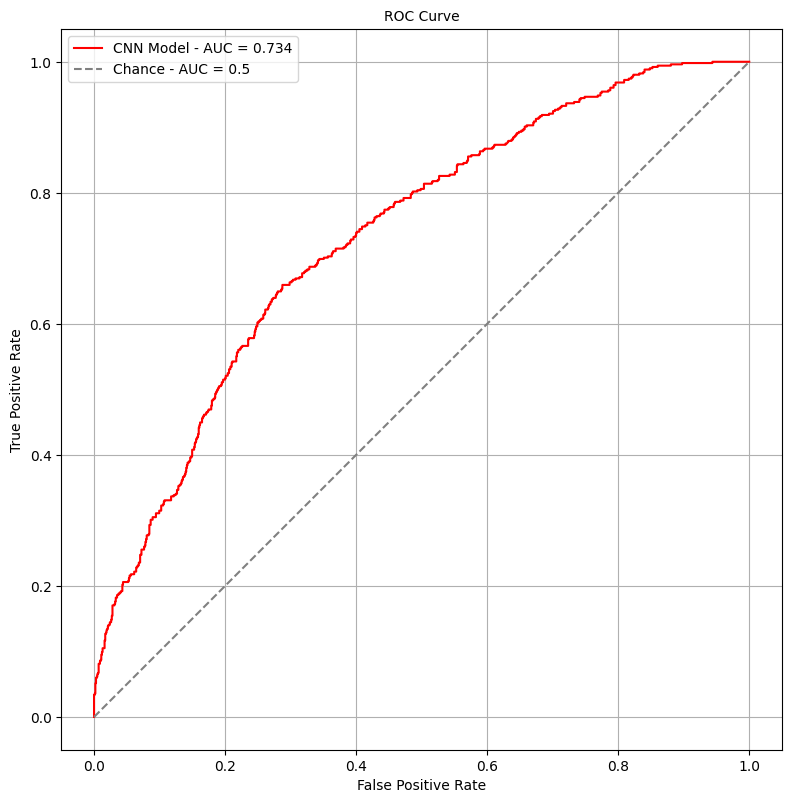

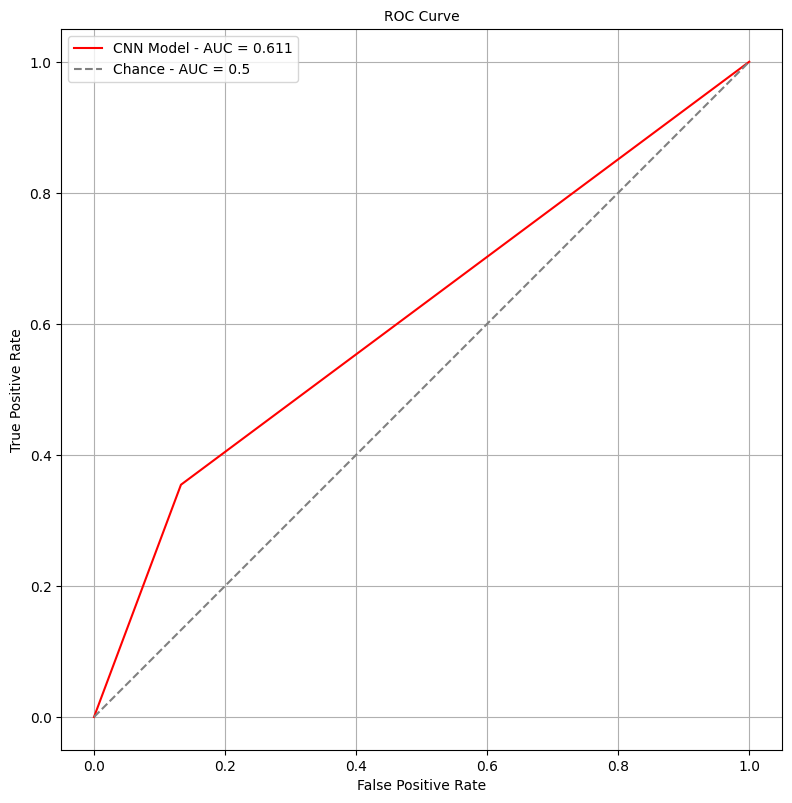

In [78]:
# Plot ROC curve for CNN model predictions
y_pred = [1 if pred >= 0.5 else 0 for pred in cnn_y_hat_prob]
plot_roc(y,  cnn_y_hat_prob)
plot_roc(y, y_pred)